
Recovered terms for X:  dX/dt ≈ Σ θ_k * Φ_k
     1:  0.000e+00
     X:  0.919788
     Y: -0.161267
   X^2:  0.000e+00
   X*Y: -0.693135
   Y^2:  0.000e+00

Recovered terms for Y:  dY/dt ≈ Σ θ_k * Φ_k
     1:  0.000e+00
     X:  0.031053
     Y: -1.407222
   X^2:  0.000e+00
   X*Y:  0.472583
   Y^2:  0.000e+00

Truth vs. learned (should be close):
α: true  1.000 | learned  0.920
β: true  0.750 | learned  0.693
γ: true  1.500 | learned  1.407
δ: true  0.500 | learned  0.473

Non-essential terms (should be ~0):
dX/dt extras: [('1', 0.0), ('X^2', -0.0), ('Y^2', -0.0)]
dY/dt extras: [('1', 0.0), ('X^2', 0.0), ('Y^2', 0.0)]


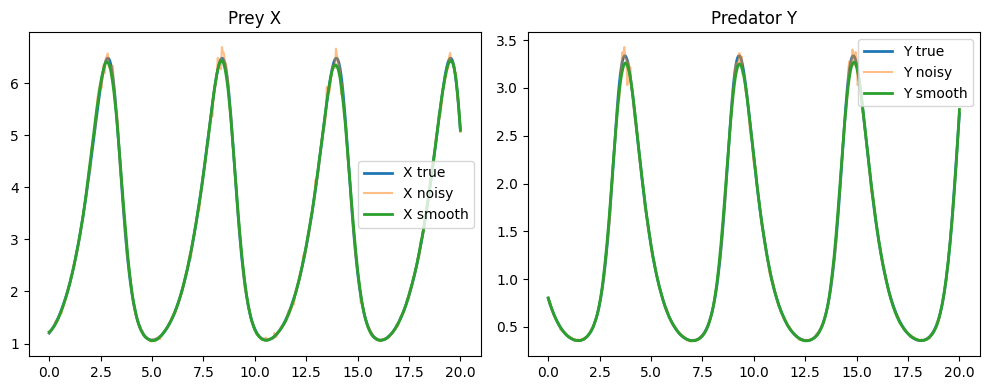

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# ---------- 1) Ground truth ODE ----------
α_true, β_true, γ_true, δ_true = 1.0, 0.75, 1.5, 0.5

def lv_rhs(t, z):
    X, Y = z
    dX = α_true*X - β_true*X*Y
    dY = δ_true*X*Y - γ_true*Y
    return [dX, dY]

# ---------- 2) Simulate & sample ----------
t0, t1, dt = 0.0, 20.0, 0.05
t_eval = np.arange(t0, t1 + dt, dt)

z0 = [1.2, 0.8]  # initial populations
sol = solve_ivp(lv_rhs, (t0, t1), z0, t_eval=t_eval, rtol=1e-9, atol=1e-12)
t = sol.t
X, Y = sol.y

# Add light noise (adjust noise_frac if you want to test robustness)
rng = np.random.default_rng(0)
noise_frac = 0.02
X_noisy = X * (1 + noise_frac * rng.standard_normal(X.shape))
Y_noisy = Y * (1 + noise_frac * rng.standard_normal(Y.shape))

# ---------- 3) Library of candidate terms Φ ----------
def make_library(Xv, Yv, include_bias=True, degree=2):
    # up to quadratic by default: {1, X, Y, X^2, XY, Y^2}
    terms = []
    names = []
    if include_bias:
        terms.append(np.ones_like(Xv)); names.append("1")
    terms += [Xv, Yv]; names += ["X", "Y"]
    if degree >= 2:
        terms += [Xv*Xv, Xv*Yv, Yv*Yv]
        names += ["X^2", "X*Y", "Y^2"]
    if degree >= 3:
        terms += [Xv**3, (Xv**2)*Yv, Xv*(Yv**2), Yv**3]
        names += ["X^3", "X^2Y", "XY^2", "Y^3"]
    Φ = np.column_stack(terms)
    return Φ, names

Φ, names = make_library(X_noisy, Y_noisy, include_bias=True, degree=2)

# ---------- 4) Derivative estimation (strong form) ----------
# Smooth, then differentiate with Savitzky–Golay
# window_length must be odd; adjust polyorder if needed
window = 31 if len(t) >= 31 else (len(t)//2)*2+1
X_smooth = savgol_filter(X_noisy, window_length=window, polyorder=3)
Y_smooth = savgol_filter(Y_noisy, window_length=window, polyorder=3)
dXdt = savgol_filter(X_noisy, window_length=window, polyorder=3, deriv=1, delta=dt)
dYdt = savgol_filter(Y_noisy, window_length=window, polyorder=3, deriv=1, delta=dt)

# Standardize features (helps Lasso)
scaler = StandardScaler(with_mean=True, with_std=True)
Φ_std = scaler.fit_transform(Φ)

# Fit two sparse regressions with CV
alphas = np.logspace(-6, -1, 30)  
lasso_X = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=100000).fit(Φ_std, dXdt)
lasso_Y = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=100000).fit(Φ_std, dYdt)

# Unscale coefficients back to original feature space
# If y is unscaled and Φ_std = (Φ - μ)/σ, then θ = θ_std / σ
σ = scaler.scale_
θX = lasso_X.coef_ / σ
θY = lasso_Y.coef_ / σ

# ---------- 5) Decode results ----------
def pretty_print(theta, eqn_label):
    print(f"\nRecovered terms for {eqn_label}:  d{eqn_label}/dt ≈ Σ θ_k * Φ_k")
    for c, nm in zip(theta, names):
        if abs(c) < 1e-6:  # tiny prints as ~0 for readability
            print(f"{nm:>6s}: {0.0: .3e}")
        else:
            print(f"{nm:>6s}: {c: .6f}")

pretty_print(θX, "X")
pretty_print(θY, "Y")

# Map against truth:
# true dX/dt = α*X + (-β)*XY  (+ 0 * others)
# true dY/dt = (-γ)*Y + δ*XY  (+ 0 * others)
def extract_term(theta, term):
    idx = names.index(term)
    return theta[idx] if idx >= 0 else np.nan

α_hat  = extract_term(θX, "X")
β_hat  = -extract_term(θX, "X*Y")
γ_hat  = -extract_term(θY, "Y")
δ_hat  =  extract_term(θY, "X*Y")

print("\nTruth vs. learned (should be close):")
print(f"α: true {α_true: .3f} | learned {α_hat: .3f}")
print(f"β: true {β_true: .3f} | learned {β_hat: .3f}")
print(f"γ: true {γ_true: .3f} | learned {γ_hat: .3f}")
print(f"δ: true {δ_true: .3f} | learned {δ_hat: .3f}")

# Inspect sparsity: coefficients that should be ~0
def summarize_sparsity(theta):
    return [(nm, float(c)) for nm, c in zip(names, theta) if nm not in ["X","Y","X*Y"]]
junk_X = summarize_sparsity(θX)
junk_Y = summarize_sparsity(θY)

print("\nNon-essential terms (should be ~0):")
print("dX/dt extras:", junk_X)
print("dY/dt extras:", junk_Y)

# ---------- Quick visual sanity plots ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, X, lw=2, label='X true')
plt.plot(t, X_noisy, alpha=0.5, label='X noisy')
plt.plot(t, X_smooth, lw=2, label='X smooth')
plt.legend(); plt.title("Prey X")
plt.subplot(1,2,2)
plt.plot(t, Y, lw=2, label='Y true')
plt.plot(t, Y_noisy, alpha=0.5, label='Y noisy')
plt.plot(t, Y_smooth, lw=2, label='Y smooth')
plt.legend(); plt.title("Predator Y")
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.688e-01, tolerance: 1.685e-01
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.562e+00, tolerance: 1.685e-01
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCac


Recovered terms for X:  dX/dt ≈ Σ θ_k * Φ_k
     Y:  0.000e+00
     X:  0.259759
   Y^2:  0.000e+00
   X*Y: -0.883903
   X^2:  0.082365
   Y^3:  0.000e+00
 X*Y^2: -0.199083
 X^2*Y:  0.000e+00
   X^3:  0.000e+00
   Y^4:  0.000e+00
 X*Y^3:  0.000e+00
X^2*Y^2:  0.000e+00
 X^3*Y:  0.000e+00
   X^4:  0.000e+00
   Y^5: -0.000812
 X*Y^4:  0.012284
X^2*Y^3:  0.002589
X^3*Y^2:  0.002003
 X^4*Y:  0.000543
   X^5: -0.000196
X/(1+X):  0.000e+00
Y/(1+Y):  0.000e+00
X^2/(1+X^2):  0.950162
Y^2/(1+Y^2):  0.000e+00
X^3/(1+X^3):  0.377220
Y^3/(1+Y^3):  0.000e+00
XY/(1+X):  0.000e+00
XY/(1+Y):  0.640263
X^2Y/(1+X^2): -0.115483
XY^2/(1+Y^2): -0.018129
X/(1+Y):  0.000e+00
Y/(1+X):  0.000e+00
X^2/(1+Y):  0.000587
Y^2/(1+X):  0.388665
log(1+X):  0.535062
log(1+Y):  0.000e+00
tanh(X):  0.000e+00
tanh(Y):  0.364187
exp(-X):  0.000e+00
exp(-Y):  0.000e+00

Recovered terms for Y:  dY/dt ≈ Σ θ_k * Φ_k
     Y:  0.000e+00
     X:  0.099469
   Y^2:  0.000e+00
   X*Y:  0.682034
   X^2:  0.000e+00
   Y^3:  0.000e+00


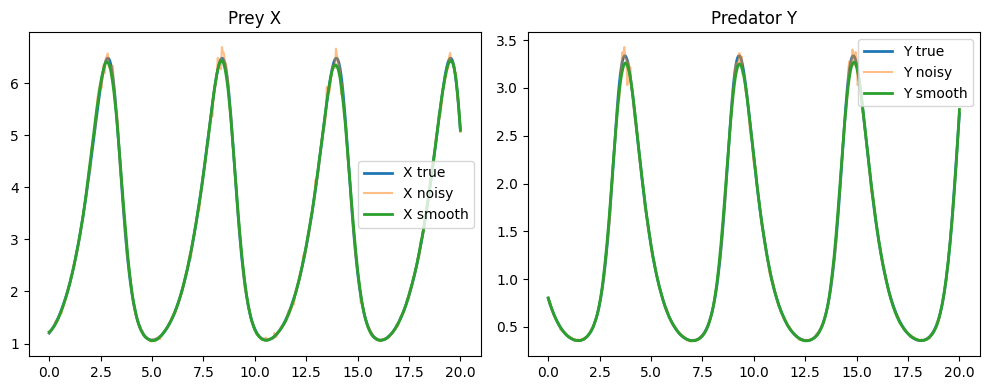

In [14]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# ---------- 1) Ground truth ODE ----------
α_true, β_true, γ_true, δ_true = 1.0, 0.75, 1.5, 0.5

def lv_rhs(t, z):
    X, Y = z
    dX = α_true*X - β_true*X*Y
    dY = δ_true*X*Y - γ_true*Y
    return [dX, dY]

# ---------- 2) Simulate & sample ----------
t0, t1, dt = 0.0, 20.0, 0.05
t_eval = np.arange(t0, t1 + dt, dt)

z0 = [1.2, 0.8]  # initial populations
sol = solve_ivp(lv_rhs, (t0, t1), z0, t_eval=t_eval, rtol=1e-9, atol=1e-12)
t = sol.t
X, Y = sol.y

# Add light noise (adjust noise_frac if you want to test robustness)
rng = np.random.default_rng(0)
noise_frac = 0.02
X_noisy = X * (1 + noise_frac * rng.standard_normal(X.shape))
Y_noisy = Y * (1 + noise_frac * rng.standard_normal(Y.shape))

# ---------- 3) Library of candidate terms Φ ----------
def make_library(Xv, Yv, include_bias=True, max_degree=5, include_specials=True):
    """
    Build an extended feature library Φ(X,Y) for sparse regression.

    Parameters
    ----------
    Xv, Yv : 1D np.ndarray
        State time series (same length).
    include_bias : bool
        If True, include a constant column "1".
    max_degree : int
        Include all monomials X^i Y^j with 1 <= i+j <= max_degree.
    include_specials : bool
        If True, append a set of safe, saturating, and nonlinear terms.

    Returns
    -------
    Φ : (n_samples, n_features) np.ndarray
        Feature matrix.
    names : list[str]
        Column names matching Φ.
    """
    Xv = np.asarray(Xv)
    Yv = np.asarray(Yv)
    terms = []
    names = []

    # ----- Bias -----
    if include_bias:
        terms.append(np.ones_like(Xv))
        names.append("1")

    # ----- All monomials up to total degree max_degree (excluding degree 0) -----
    # Adds X, Y, X^2, XY, Y^2, X^3, X^2Y, XY^2, Y^3, ... up to max_degree
    for d in range(1, max_degree + 1):
        for i in range(d + 1):
            j = d - i
            term = (Xv ** i) * (Yv ** j)
            # Build a readable name
            name_parts = []
            if i > 0:
                name_parts.append("X" if i == 1 else f"X^{i}")
            if j > 0:
                name_parts.append("Y" if j == 1 else f"Y^{j}")
            nm = "*".join(name_parts)
            terms.append(term)
            names.append(nm)

    if include_specials:
        # Safe eps for logs/tanh domain considerations
        eps = 1e-12

        # ----- Saturating single-variable transforms -----
        specials = [
            (Xv / (1.0 + Xv),          "X/(1+X)"),
            (Yv / (1.0 + Yv),          "Y/(1+Y)"),
            ((Xv**2) / (1.0 + Xv**2),  "X^2/(1+X^2)"),
            ((Yv**2) / (1.0 + Yv**2),  "Y^2/(1+Y^2)"),
            ((Xv**3) / (1.0 + Xv**3),  "X^3/(1+X^3)"),
            ((Yv**3) / (1.0 + Yv**3),  "Y^3/(1+Y^3)"),
        ]

        # ----- Cross-saturating interactions (no division by raw X or Y) -----
        specials += [
            ((Xv * Yv) / (1.0 + Xv),          "XY/(1+X)"),
            ((Xv * Yv) / (1.0 + Yv),          "XY/(1+Y)"),
            ((Xv**2 * Yv) / (1.0 + Xv**2),    "X^2Y/(1+X^2)"),
            ((Xv * Yv**2) / (1.0 + Yv**2),    "XY^2/(1+Y^2)"),
        ]

        # ----- Mixed coupling / inhibition style terms -----
        specials += [
            (Xv / (1.0 + Yv),               "X/(1+Y)"),
            (Yv / (1.0 + Xv),               "Y/(1+X)"),
            ((Xv**2) / (1.0 + Yv),          "X^2/(1+Y)"),
            ((Yv**2) / (1.0 + Xv),          "Y^2/(1+X)"),
        ]

        # ----- Smooth nonlinearities (domain-safe for positive states) -----
        specials += [
            (np.log1p(Xv + eps),            "log(1+X)"),
            (np.log1p(Yv + eps),            "log(1+Y)"),
            (np.tanh(Xv),                   "tanh(X)"),
            (np.tanh(Yv),                   "tanh(Y)"),
            (np.exp(-Xv),                   "exp(-X)"),
            (np.exp(-Yv),                   "exp(-Y)"),
        ]

        # Append specials
        for arr, nm in specials:
            terms.append(arr)
            names.append(nm)

    Φ = np.column_stack(terms)
    return Φ, names

"""
example
Xv = np.array([1, 2, 3])
Yv = np.array([4, 5, 6])
Φ, names = make_library(Xv, Yv, degree=2)
this means names = ['1', 'X', 'Y', 'X^2', 'X*Y', 'Y^2']
[[ 1, 1, 4, 1, 4, 16],
 [ 1, 2, 5, 4,10, 25],
 [ 1, 3, 6, 9,18, 36]]"""

Φ, names = make_library(X_noisy, Y_noisy, include_bias= False,
                        include_specials=True, max_degree=5)

# Scale (center + std) — OK since there's no constant column now
scaler = StandardScaler(with_mean=True, with_std=True)
Φ_std = scaler.fit_transform(Φ)
# This line is just a preprocessing step that standardizes all columns in the feature/terms matrix
#we need this because we are doing lasso (L1) regression which learns sparse coefficients by penalizing their absolute magnitude
#so if some features are much larger or smaller in scale than others, the penalty will unevenly affect them.

# Lasso (mean = 0, std = 1, range (-2,2))
lasso_X = LassoCV(alphas=np.logspace(-6, 1, 40), cv=5, fit_intercept=False, max_iter=900000).fit(Φ_std, dXdt)
lasso_Y = LassoCV(alphas=np.logspace(-6, 1, 40), cv=5, fit_intercept=False, max_iter=900000).fit(Φ_std, dYdt)

# Unscale: θ = θ_std / σ  
σ = scaler.scale_
θX = lasso_X.coef_ / σ
θY = lasso_Y.coef_ / σ

# ---------- 5) Decode results ----------
def pretty_print(theta, eqn_label):
    print(f"\nRecovered terms for {eqn_label}:  d{eqn_label}/dt ≈ Σ θ_k * Φ_k")
    for c, nm in zip(theta, names):
        if abs(c) < 1e-6:  # tiny prints as ~0 for readability
            print(f"{nm:>6s}: {0.0: .3e}")
        else:
            print(f"{nm:>6s}: {c: .6f}")

pretty_print(θX, "X")
pretty_print(θY, "Y")

# Map against truth:
# true dX/dt = α*X + (-β)*XY  (+ 0 * others)
# true dY/dt = (-γ)*Y + δ*XY  (+ 0 * others)
def extract_term(theta, term):
    idx = names.index(term)
    return theta[idx] if idx >= 0 else np.nan

α_hat  = extract_term(θX, "X")
β_hat  = -extract_term(θX, "X*Y")
γ_hat  = -extract_term(θY, "Y")
δ_hat  =  extract_term(θY, "X*Y")

print("\nTruth vs. learned (should be close):")
print(f"α: true {α_true: .3f} | learned {α_hat: .3f}")
print(f"β: true {β_true: .3f} | learned {β_hat: .3f}")
print(f"γ: true {γ_true: .3f} | learned {γ_hat: .3f}")
print(f"δ: true {δ_true: .3f} | learned {δ_hat: .3f}")

# Inspect sparsity: coefficients that should be ~0
def summarize_sparsity(theta):
    return [(nm, float(c)) for nm, c in zip(names, theta) if nm not in ["X","Y","X*Y"]]
junk_X = summarize_sparsity(θX)
junk_Y = summarize_sparsity(θY)

print("\nNon-essential terms (should be ~0):")
print("dX/dt extras:", junk_X)
print("dY/dt extras:", junk_Y)

# ---------- Quick visual sanity plots ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, X, lw=2, label='X true')
plt.plot(t, X_noisy, alpha=0.5, label='X noisy')
plt.plot(t, X_smooth, lw=2, label='X smooth')
plt.legend(); plt.title("Prey X")
plt.subplot(1,2,2)
plt.plot(t, Y, lw=2, label='Y true')
plt.plot(t, Y_noisy, alpha=0.5, label='Y noisy')
plt.plot(t, Y_smooth, lw=2, label='Y smooth')
plt.legend(); plt.title("Predator Y")
plt.tight_layout()
plt.show()


Increased the noise to test if model would still accurately predict data 


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.685e-01
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+00, tolerance: 1.685e-01
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCac


Recovered terms for X:  dX/dt ≈ Σ θ_k * Φ_k
     Y:  0.000e+00
     X:  3.874266
   Y^2:  0.000e+00
   X*Y: -3.083420
   X^2:  0.000e+00
   Y^3:  0.258650
 X*Y^2:  0.000e+00
 X^2*Y:  0.000e+00
   X^3:  0.000e+00
   Y^4:  0.000e+00
 X*Y^3:  0.046580
X^2*Y^2:  0.000e+00
 X^3*Y:  0.029150
   X^4:  0.000e+00
   Y^5: -0.014960
 X*Y^4:  0.028197
X^2*Y^3: -0.033321
X^3*Y^2:  0.016399
 X^4*Y: -0.005401
   X^5:  0.000277
X/(1+X):  0.000e+00
Y/(1+Y):  0.000e+00
X^2/(1+X^2):  0.000e+00
Y^2/(1+Y^2):  0.000e+00
X^3/(1+X^3):  3.169284
Y^3/(1+Y^3):  1.719860
XY/(1+X):  0.000e+00
XY/(1+Y):  6.359945
X^2Y/(1+X^2):  2.290301
XY^2/(1+Y^2): -3.093965
X/(1+Y):  0.087186
Y/(1+X):  10.191909
X^2/(1+Y): -0.782790
Y^2/(1+X): -3.358963
log(1+X):  5.235276
log(1+Y):  0.000e+00
tanh(X):  13.846790
tanh(Y): -1.095279
exp(-X):  31.947509
exp(-Y):  6.019557

Recovered terms for Y:  dY/dt ≈ Σ θ_k * Φ_k
     Y:  0.000e+00
     X:  0.000e+00
   Y^2:  0.000e+00
   X*Y:  1.641184
   X^2:  0.000e+00
   Y^3:  0.102412
 X*

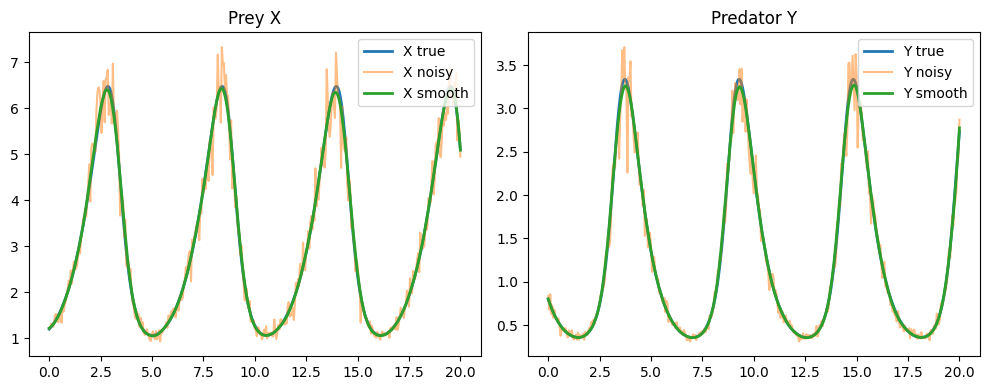

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# ---------- 1) Ground truth ODE ----------
α_true, β_true, γ_true, δ_true = 1.0, 0.75, 1.5, 0.5

def lv_rhs(t, z):
    X, Y = z
    dX = α_true*X - β_true*X*Y
    dY = δ_true*X*Y - γ_true*Y
    return [dX, dY]

# ---------- 2) Simulate & sample ----------
t0, t1, dt = 0.0, 20.0, 0.05
t_eval = np.arange(t0, t1 + dt, dt)

z0 = [1.2, 0.8]  # initial populations
sol = solve_ivp(lv_rhs, (t0, t1), z0, t_eval=t_eval, rtol=1e-9, atol=1e-12)
t = sol.t
X, Y = sol.y

# Add light noise (adjust noise_frac if you want to test robustness)
rng = np.random.default_rng(0)
noise_frac = 0.08
X_noisy = X * (1 + noise_frac * rng.standard_normal(X.shape))
Y_noisy = Y * (1 + noise_frac * rng.standard_normal(Y.shape))

# ---------- 3) Library of candidate terms Φ ----------
def make_library(Xv, Yv, include_bias=True, max_degree=5, include_specials=True):
    """
    Build an extended feature library Φ(X,Y) for sparse regression.

    Parameters
    ----------
    Xv, Yv : 1D np.ndarray
        State time series (same length).
    include_bias : bool
        If True, include a constant column "1".
    max_degree : int
        Include all monomials X^i Y^j with 1 <= i+j <= max_degree.
    include_specials : bool
        If True, append a set of safe, saturating, and nonlinear terms.

    Returns
    -------
    Φ : (n_samples, n_features) np.ndarray
        Feature matrix.
    names : list[str]
        Column names matching Φ.
    """
    Xv = np.asarray(Xv)
    Yv = np.asarray(Yv)
    terms = []
    names = []

    # ----- Bias -----
    if include_bias:
        terms.append(np.ones_like(Xv))
        names.append("1")

    # ----- All monomials up to total degree max_degree (excluding degree 0) -----
    # Adds X, Y, X^2, XY, Y^2, X^3, X^2Y, XY^2, Y^3, ... up to max_degree
    for d in range(1, max_degree + 1):
        for i in range(d + 1):
            j = d - i
            term = (Xv ** i) * (Yv ** j)
            # Build a readable name
            name_parts = []
            if i > 0:
                name_parts.append("X" if i == 1 else f"X^{i}")
            if j > 0:
                name_parts.append("Y" if j == 1 else f"Y^{j}")
            nm = "*".join(name_parts)
            terms.append(term)
            names.append(nm)

    if include_specials:
        # Safe eps for logs/tanh domain considerations
        eps = 1e-12

        # ----- Saturating single-variable transforms -----
        specials = [
            (Xv / (1.0 + Xv),          "X/(1+X)"),
            (Yv / (1.0 + Yv),          "Y/(1+Y)"),
            ((Xv**2) / (1.0 + Xv**2),  "X^2/(1+X^2)"),
            ((Yv**2) / (1.0 + Yv**2),  "Y^2/(1+Y^2)"),
            ((Xv**3) / (1.0 + Xv**3),  "X^3/(1+X^3)"),
            ((Yv**3) / (1.0 + Yv**3),  "Y^3/(1+Y^3)"),
        ]

        # ----- Cross-saturating interactions (no division by raw X or Y) -----
        specials += [
            ((Xv * Yv) / (1.0 + Xv),          "XY/(1+X)"),
            ((Xv * Yv) / (1.0 + Yv),          "XY/(1+Y)"),
            ((Xv**2 * Yv) / (1.0 + Xv**2),    "X^2Y/(1+X^2)"),
            ((Xv * Yv**2) / (1.0 + Yv**2),    "XY^2/(1+Y^2)"),
        ]

        # ----- Mixed coupling / inhibition style terms -----
        specials += [
            (Xv / (1.0 + Yv),               "X/(1+Y)"),
            (Yv / (1.0 + Xv),               "Y/(1+X)"),
            ((Xv**2) / (1.0 + Yv),          "X^2/(1+Y)"),
            ((Yv**2) / (1.0 + Xv),          "Y^2/(1+X)"),
        ]

        # ----- Smooth nonlinearities (domain-safe for positive states) -----
        specials += [
            (np.log1p(Xv + eps),            "log(1+X)"),
            (np.log1p(Yv + eps),            "log(1+Y)"),
            (np.tanh(Xv),                   "tanh(X)"),
            (np.tanh(Yv),                   "tanh(Y)"),
            (np.exp(-Xv),                   "exp(-X)"),
            (np.exp(-Yv),                   "exp(-Y)"),
        ]

        # Append specials
        for arr, nm in specials:
            terms.append(arr)
            names.append(nm)

    Φ = np.column_stack(terms)
    return Φ, names

"""
example
Xv = np.array([1, 2, 3])
Yv = np.array([4, 5, 6])
Φ, names = make_library(Xv, Yv, degree=2)
this means names = ['1', 'X', 'Y', 'X^2', 'X*Y', 'Y^2']
[[ 1, 1, 4, 1, 4, 16],
 [ 1, 2, 5, 4,10, 25],
 [ 1, 3, 6, 9,18, 36]]"""

Φ, names = make_library(X_noisy, Y_noisy, include_bias= False,
                        include_specials=True, max_degree=5)

# Scale (center + std) — OK since there's no constant column now
scaler = StandardScaler(with_mean=True, with_std=True)
Φ_std = scaler.fit_transform(Φ)
# This line is just a preprocessing step that standardizes all columns in the feature/terms matrix
#we need this because we are doing lasso (L1) regression which learns sparse coefficients by penalizing their absolute magnitude
#so if some features are much larger or smaller in scale than others, the penalty will unevenly affect them.

# Lasso (mean = 0, std = 1, range (-2,2))
lasso_X = LassoCV(alphas=np.logspace(-6, 1, 40), cv=5, fit_intercept=False, max_iter=900000).fit(Φ_std, dXdt)
lasso_Y = LassoCV(alphas=np.logspace(-6, 1, 40), cv=5, fit_intercept=False, max_iter=900000).fit(Φ_std, dYdt)

# Unscale: θ = θ_std / σ  
σ = scaler.scale_
θX = lasso_X.coef_ / σ
θY = lasso_Y.coef_ / σ

# ---------- 5) Decode results ----------
def pretty_print(theta, eqn_label):
    print(f"\nRecovered terms for {eqn_label}:  d{eqn_label}/dt ≈ Σ θ_k * Φ_k")
    for c, nm in zip(theta, names):
        if abs(c) < 1e-6:  # tiny prints as ~0 for readability
            print(f"{nm:>6s}: {0.0: .3e}")
        else:
            print(f"{nm:>6s}: {c: .6f}")

pretty_print(θX, "X")
pretty_print(θY, "Y")

# Map against truth:
# true dX/dt = α*X + (-β)*XY  (+ 0 * others)
# true dY/dt = (-γ)*Y + δ*XY  (+ 0 * others)
def extract_term(theta, term):
    idx = names.index(term)
    return theta[idx] if idx >= 0 else np.nan

α_hat  = extract_term(θX, "X")
β_hat  = -extract_term(θX, "X*Y")
γ_hat  = -extract_term(θY, "Y")
δ_hat  =  extract_term(θY, "X*Y")

print("\nTruth vs. learned (should be close):")
print(f"α: true {α_true: .3f} | learned {α_hat: .3f}")
print(f"β: true {β_true: .3f} | learned {β_hat: .3f}")
print(f"γ: true {γ_true: .3f} | learned {γ_hat: .3f}")
print(f"δ: true {δ_true: .3f} | learned {δ_hat: .3f}")

# Inspect sparsity: coefficients that should be ~0
def summarize_sparsity(theta):
    return [(nm, float(c)) for nm, c in zip(names, theta) if nm not in ["X","Y","X*Y"]]
junk_X = summarize_sparsity(θX)
junk_Y = summarize_sparsity(θY)

print("\nNon-essential terms (should be ~0):")
print("dX/dt extras:", junk_X)
print("dY/dt extras:", junk_Y)

# ---------- Quick visual sanity plots ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, X, lw=2, label='X true')
plt.plot(t, X_noisy, alpha=0.5, label='X noisy')
plt.plot(t, X_smooth, lw=2, label='X smooth')
plt.legend(); plt.title("Prey X")
plt.subplot(1,2,2)
plt.plot(t, Y, lw=2, label='Y true')
plt.plot(t, Y_noisy, alpha=0.5, label='Y noisy')
plt.plot(t, Y_smooth, lw=2, label='Y smooth')
plt.legend(); plt.title("Predator Y")
plt.tight_layout()
plt.show()


Limitations of only classical Parameter fitting: 
You must decide in advance which terms exist.
If you omit an important biological effect (say, immune exhaustion or BMI modulation), no amount of fitting will “discover” it.

If you include too many speculative terms, nonlinear optimization becomes underdetermined and can give many parameter sets that fit equally well.

Requires a good initial guess and good identifiability; otherwise it can wander or converge to non-physical minima.

Lasso - Which biological processes actually show up?
Classical - Given this structure, what are the patient-specific parameters?
optimization - Given the calibrated model, how much chemo/immuno/endocrine do we give?